# Parsing of Cells Data (Headers, Body, Footer)
## Step 01: crop image from original image based on contour.
## Step 02: transform cropped image to optimise for ocr.
## Step 03: parse each section based on it's own rules.

In [1]:
from lib.relative import path_join
from lib.image.line_detection import get_contours_of_table
from cv2 import imread, IMREAD_UNCHANGED

test_image = imread(path_join("../", "test_files", "3516793810.tif"), IMREAD_UNCHANGED)

headers, body, footer = get_contours_of_table(test_image)

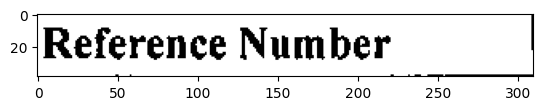

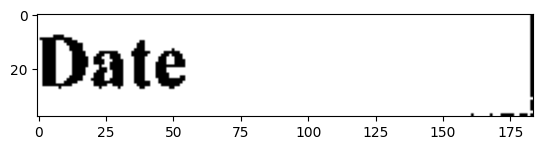

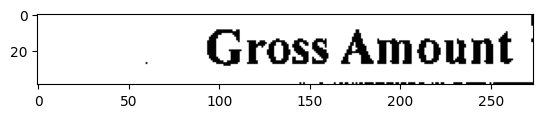

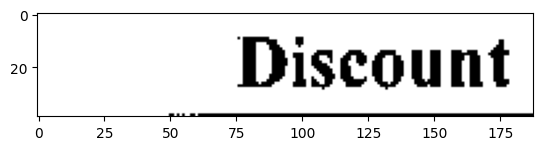

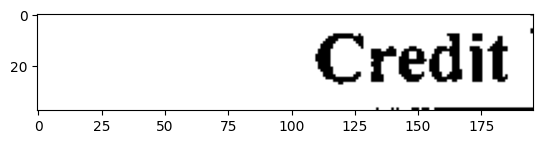

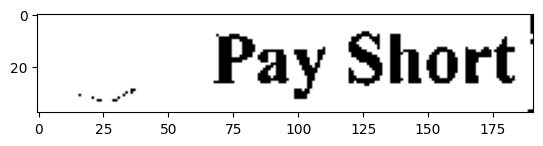

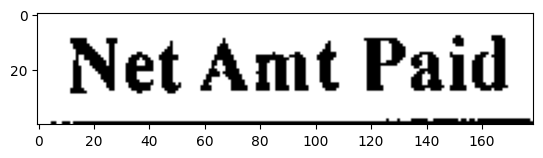

In [2]:
from lib.image.cell import cut_cells, cell_optimise_for_scan
from matplotlib.pyplot import figure, imshow

headers_cut = cut_cells(headers, test_image)

for index, header_cut in enumerate(headers_cut):
    figure(index)
    imshow(header_cut, cmap='gray')

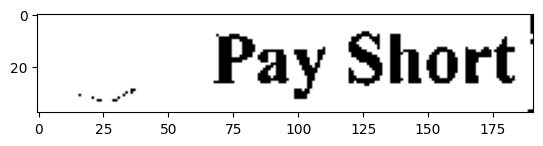

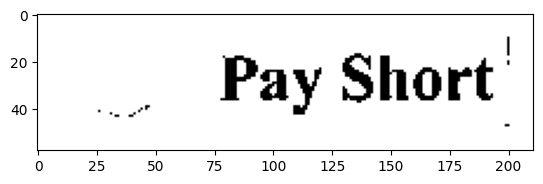

In [3]:
from cv2 import boundingRect, resize, dilate, erode, getStructuringElement, MORPH_RECT, BORDER_CONSTANT, INTER_CUBIC, \
    copyMakeBorder

figure(0)
to_sanitize = headers_cut[5]
imshow(to_sanitize, cmap='gray')

figure(1)
kernel = getStructuringElement(MORPH_RECT, (2, 1))
border_corrected = copyMakeBorder(to_sanitize, 10, 10, 10, 10, BORDER_CONSTANT, value=[255, 255])
imshow(border_corrected, cmap='gray')


In [4]:
from lib.image.cell import cell_line_to_text

cell_line_to_text(border_corrected)

'Pay Short\n'

Above steps are consolidated with `cell_optimise_for_scan` and `cell_line_to_text`.

In [5]:
headers = [cell_line_to_text(cell_optimise_for_scan(header_cut)) for header_cut in headers_cut]
headers


['Reference Number - |\n',
 'Date | |\n',
 '_ Gross Amount\n',
 '; Discount\n',
 'Credit\n',
 '_, Pay Short’\n',
 'Net Amt Paid\n']

# Body Parsing
- Body cell can have multiple rows, hence need to compensate for that.

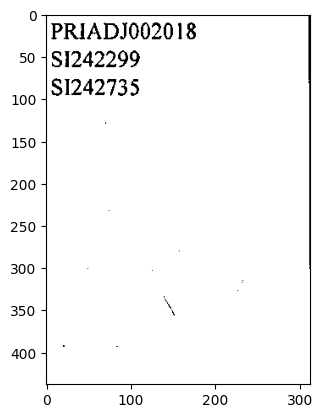

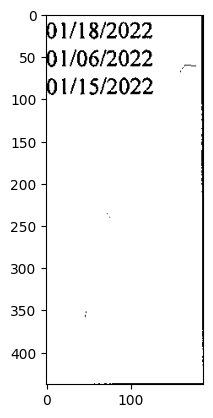

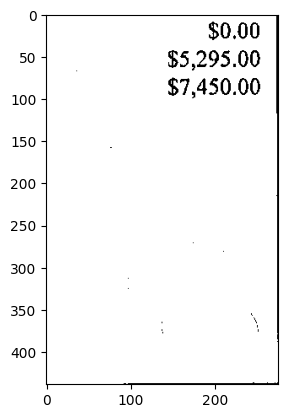

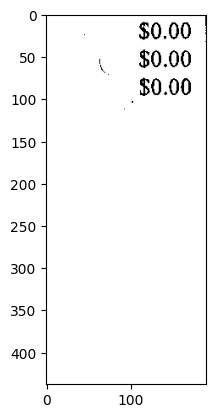

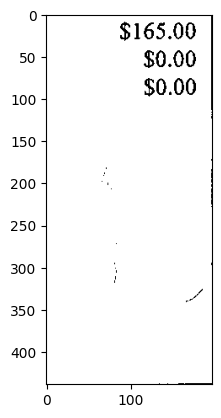

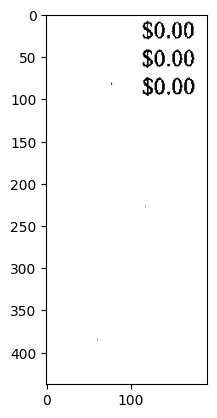

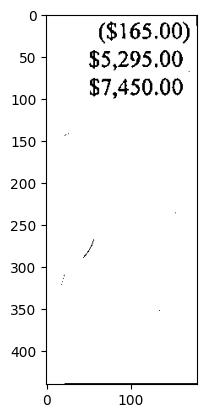

In [6]:
from PIL.Image import fromarray
from pytesseract import pytesseract

body_cuts = cut_cells(body, test_image)

for index, body_cut in enumerate(body_cuts):
    figure(index)
    imshow(body_cut, cmap='gray')

'PRIADJ002018\n$1242299\n$1242735\n\n\\\n'

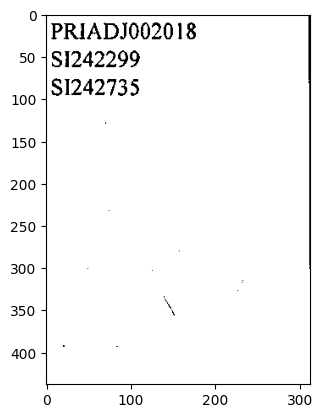

In [7]:
import cv2
import numpy as np
from cv2 import GaussianBlur
from lib.image.otsu_binarization import otsus_binarization

cell = body_cuts[0]
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(cell, -1, kernel)
imshow(sharpened, cmap='gray')

pillow_image = fromarray(sharpened)

# assume a single uniform block
texts = pytesseract.image_to_string(pillow_image, config='--psm 6')
texts

In [8]:
body = [cell_line_to_text(cell_optimise_for_scan(body_cut)) for body_cut in body_cuts]

In [9]:
from enum import Enum


class ColumnType(Enum):
    string = 'string'
    date = 'date'
    currency = 'currency'


expected_body_columns = [ColumnType.string, ColumnType.date, ColumnType.currency, ColumnType.currency,
                         ColumnType.currency, ColumnType.currency, ColumnType.currency]

In [10]:
# string type
separated_rows = [row.split('\n') for row in body]
separated_rows

[['PRIADJ002018', '$1242299', '$1242735', '', '\\ 7', ''],
 ['01/18/2022', '01/06/2022 _', '01/15/2022', ''],
 ['$0.00', '| $5,295.00', '$7,450.00', ''],
 ['$0.00', '$0.00', '$0.00', ''],
 ['$165.00', '$0.00', '$0.00', '', ': yy', ''],
 ['$0.00', '$0.00', "' $0.00", ''],
 ['($165.00)', '$5,295.00', '$7,450.00', '', '/', '']]

In [11]:
import re

# using date field to find out number of rows
rgx = re.compile('.*(\d{2}\/\d{2}\/\d{4}).*')
dates = [rgx.findall(date_row) for date_row in separated_rows[1]]
dates = [date for date in dates if date]
dates

[['01/18/2022'], ['01/06/2022'], ['01/15/2022']]

In [12]:
# using currency field to find out number of rows
rgx = re.compile('.*(\$[\.\,\d]*).*')
currencies = [rgx.findall(currency_row) for currency_row in separated_rows[2]]
currencies = [currency for currency in currencies if currency]
currencies

[['$0.00'], ['$5,295.00'], ['$7,450.00']]

In [13]:
result = []

for index, col_type in enumerate(expected_body_columns):
    if col_type == ColumnType.string:
        filtered = [row for row in separated_rows[index] if row]
        result.append(filtered)
    elif col_type == ColumnType.currency:
        rgx = re.compile('.*(\$[\.\,\d]*).*')
        currencies = [rgx.findall(currency_row) for currency_row in separated_rows[index]]
        currencies = [currency for currency in currencies if currency]
        result.append(currencies)
    elif col_type == ColumnType.date:
        rgx = re.compile('.*(\d{2}\/\d{2}\/\d{4}).*')
        dates = [rgx.findall(date_row) for date_row in separated_rows[index]]
        dates = [date for date in dates if date]
        result.append(dates)
result

[['PRIADJ002018', '$1242299', '$1242735', '\\ 7'],
 [['01/18/2022'], ['01/06/2022'], ['01/15/2022']],
 [['$0.00'], ['$5,295.00'], ['$7,450.00']],
 [['$0.00'], ['$0.00'], ['$0.00']],
 [['$165.00'], ['$0.00'], ['$0.00']],
 [['$0.00'], ['$0.00'], ['$0.00']],
 [['$165.00'], ['$5,295.00'], ['$7,450.00']]]

In [14]:
lengths_of_columns = [len(col) for col in result]


def most_common(lst):
    return max(set(lst), key=lst.count)


most_common(lengths_of_columns)

3

In [15]:
# left or right most vertexes should almost align.


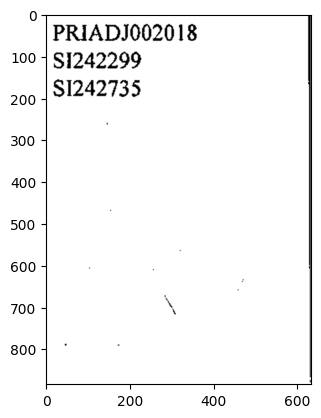

In [16]:
body = [cell_optimise_for_scan(body_cut) for body_cut in body_cuts][0]

imshow(body, cmap='gray')


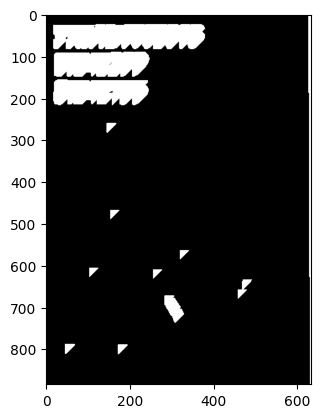

In [17]:
ret, mask = cv2.threshold(body, 180, 255, cv2.THRESH_BINARY)
image_final = cv2.bitwise_and(body, body, mask=mask)
ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
dilated = cv2.dilate(new_img, kernel, iterations=20)

imshow(dilated, cmap='gray')


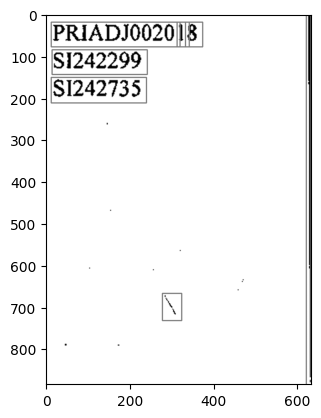

In [18]:
from cv2 import rectangle, groupRectangles
from lib.image.draw import rectangle_points_from_contours
from lib.image.parse_body import parse_body, get_body_rows

body = [cell_optimise_for_scan(body_cut) for body_cut in body_cuts][0]
column_rows = get_body_rows(body)

for index, column_row in enumerate(column_rows):
    rectangle(body, *rectangle_points_from_contours(column_row, 5), (125, 0, 0), 2)

imshow(body, cmap='gray')